Codes for making Supplementary Figure 11 in the manuscript.

In [1]:
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(GenomicRanges))
suppressMessages(library(gridExtra))
suppressMessages(library(scales))

data_dir <- '../../analysis/real_data/data/validation/brain/ENCODE'
fig_dir <- '../../analysis/manuscript/figures/brain'
output_dir <- '../../analysis/real_data/output'

In [2]:
bed_files <- list.files(data_dir)
bed_files <- bed_files[grepl('.bed', bed_files)]
bed_files

[1] "ENCFF074YTY.bed" "ENCFF970BCI.bed"

In [3]:
bed <- as.data.frame(read.table(sprintf("%s/%s", data_dir, bed_files[1]),
                                header = FALSE, sep="\t",stringsAsFactors=FALSE, quote=""))

In [4]:
table(bed$V4)
head(bed)


   EnhA1    EnhA2   EnhBiv    EnhG1    EnhG2    EnhWk      Het    Quies 
   23985    34130     7104    14090     2391    77592    24333    65756 
  ReprPC ReprPCWk     TssA   TssBiv  TssFlnk TssFlnkD TssFlnkU       Tx 
   16984    21947    20707     7405    28048    23149    15216    29927 
    TxWk ZNF/Rpts 
   96493     8145 

,V1,V2,V3,V4,V5,V6,V7,V8,V9
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>
1,chr1,10000,177200,Quies,0,.,10000,177200,"255,255,255"
2,chr1,257849,297849,Quies,0,.,257849,297849,"255,255,255"
3,chr1,586020,778420,Quies,0,.,586020,778420,"255,255,255"
4,chr1,778420,778820,TssA,0,.,778420,778820,"255,0,0"
5,chr1,778820,779020,TssFlnk,0,.,778820,779020,"255,69,0"
6,chr1,779020,779220,TssA,0,.,779020,779220,"255,0,0"


Definition of different chromatin states:

* https://pmc.ncbi.nlm.nih.gov/articles/PMC4530010/
* A 15-state model: "The active states (associated with expressed genes) consist of active TSS-proximal promoter states (TssA, TssAFlnk), a transcribed state at the 5’ and 3’ end of genes showing both promoter and enhancer signatures (TxFlnk), actively-transcribed states (Tx, TxWk), enhancer states (Enh, EnhG), and a state associated with zinc finger protein genes (ZNF/Rpts). The inactive states consist of constitutive heterochromatin (Het), bivalent regulatory states (TssBiv, BivFlnk, EnhBiv), repressed Polycomb states (ReprPC, ReprPCWk), and a quiescent state (Quies) which covers on average 68% of each reference epigenome."
* With H3K27ac data, a 18-state model: " In the subset of 98 reference epigenomes that also included H3K27ac data, we also learned an 18-state model (Extended Data 2c, Table S3b), enabling us to distinguish enhancer states containing strong H3K27ac signal (EnhA1, EnhA2), which showed higher DNA accessibility (Extended Data 3a), lower methylation (Extended Data 3b), and higher TF binding (Extended Data 2c) than enhancers lacking H3K27ac."

In this case, we have the annotation results from a 18-state model. It seems that EnhA1 and EnhA2 contains stronger enhancer signals, and we choose it as 'silver standard' to compare against scMultiMap annotations.

In [5]:
sig_assay_df <- GenomicRanges::makeGRangesFromDataFrame(df = bed[bed$V4 %in% c('EnhA1', 'EnhA2'),], 
                                                        seqnames.field = 'V1',
                                                        start.field = 'V2',
                                                        end.field = 'V3',
                                                        keep.extra.columns=TRUE)

# Load results on brain data

In [6]:
source('reproducibility_helper.R')
source('validation_helper.R')
datasets <- 'brain_CG'
cts <- c('Excitatory', 'Inhibitory', 'Oligodendrocytes')

res_list <- list()
for(ct in cts){
    res_list_ct <- list()
    res_list_ct[['proposed']] <- load_proposed(ct, datasets = datasets,
                                               fn_suffix = '_batch_adjusted',
                                               output_dir = output_dir)
    res_list_ct[['SCENT']] <- load_SCENT(ct, n_sets=20, 
                                         datasets = datasets,
                                         fn_suffix =  '_batch_as_covar_adjusted_n_bootstrap_5000',
                                         output_dir = output_dir) 
    res_list_ct[['Signac']] <- load_Signac(ct, datasets = datasets,
                                          fn_suffix = '_permu_adjusted',
                                          output_dir = output_dir)
    res_list[[ct]] <- res_list_ct
}

In [7]:
pvar <- 'adj_pval'
p_cutoff <- 0.2

ENCODE_overlap_mat <- c()
for(i in 1:2){
    bed <- as.data.frame(read.table(sprintf("%s/%s", data_dir, bed_files[i]),
                                header = FALSE, sep="\t",stringsAsFactors=FALSE, quote=""))
    sig_assay_df <- GenomicRanges::makeGRangesFromDataFrame(df = bed[bed$V4 %in% c('EnhA1', 'EnhA2'),], 
                                                      seqnames.field = 'V1',
                                                      start.field = 'V2',
                                                      end.field = 'V3',
                                                            keep.extra.columns=TRUE)
    for(ct in cts){
        print(ct)
        for(method in c('proposed','Signac','SCENT')){
            res_df <- res_list[[ct]][[method]][[1]]
            sig_res_inds <- sig_res_inds <- res_df[[pvar]] < p_cutoff
            grange_peaks <- Signac::StringToGRanges(unique(res_df$peak), sep = c('-', '-'))
            grange_peaks_sig <- Signac::StringToGRanges(unique(res_df$peak[sig_res_inds]), sep = c('-', '-'))
            
            bovp = with(GenomicRanges::findOverlaps(grange_peaks, sig_assay_df),
                           data.frame(d1_idx=queryHits,
                                      d2_idx=subjectHits))
            sovp = with(GenomicRanges::findOverlaps(grange_peaks_sig, 
                                                sig_assay_df),
                           data.frame(d1_idx=queryHits,
                                      d2_idx=subjectHits))
            # all peaks evaluated
            n_total <- length(unique(res_df$peak))
            # peaks that overlap with ENCODE annotations
            n_assay <- length(unique(bovp$d1_idx))
            # peaks that are both significant and overlapped with ENCODE annotations
            n_assay_sig <- length(unique(sovp$d1_idx))
            # significant peaks
            n_sig <- length(unique(res_df$peak[sig_res_inds]))

            # make a two-by-two table
            A <- n_assay_sig
            B <- n_sig - A
            C <- n_assay - A
            D <- n_total - (A + B + C)
    
            oddsratio <- (A*D)/(B*C)
            pval <- phyper(n_assay_sig, n_assay, n_total-n_assay, n_sig, lower.tail=F)

            print(c(oddsratio, -log10(pval)))
            ENCODE_overlap_mat <- rbind(ENCODE_overlap_mat,
                                    c(A, B, C, D, oddsratio, pval, method, ct, bed_files[i]))
        }
    }
}

[1] "Excitatory"


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.



[1]  1.38112 14.25529
[1] 1.257366 6.994324
[1]  1.484017 18.737032
[1] "Inhibitory"
[1]  1.593012 22.981384
[1] 1.379796 8.180891
[1] 1.319664 9.637031
[1] "Oligodendrocytes"
[1]  1.932283 15.632753
[1]  2.09710 28.79606
[1] 1.368451 8.246286
[1] "Excitatory"
[1] 1.119540 2.544777
[1] 1.124141 2.483751
[1] 1.225575 5.874789
[1] "Inhibitory"
[1] 1.231598 5.779876
[1] 1.143998 2.186476
[1] 1.122144 2.496784
[1] "Oligodendrocytes"
[1]  1.905493 14.698452
[1]  1.873713 20.749332
[1] 1.372046 8.413298


# Visualization

In [8]:
colors <- c('#DC267F', '#648FFF', '#FFB000')
names(colors) <- c('scMultiMap','SCENT','Signac')

uniform_bs <- 22

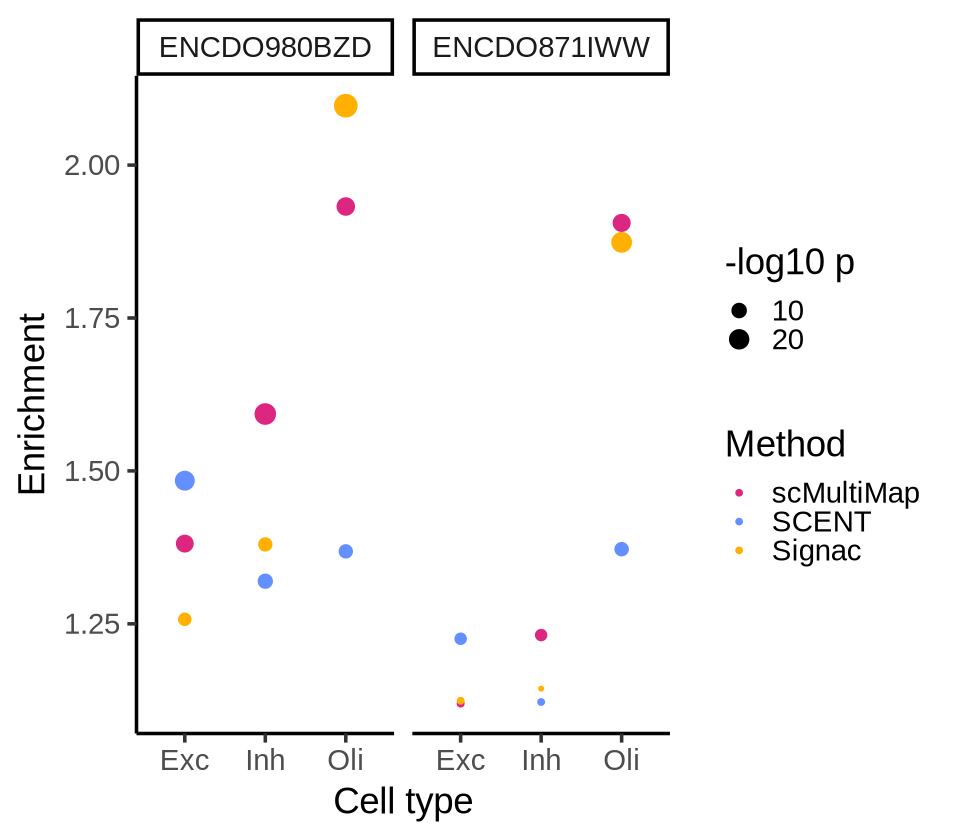

In [9]:
ENCODE_overlap <- data.frame(ENCODE_overlap_mat)
colnames(ENCODE_overlap)[5:9] <- c('OR', 'pval', 'method', 'cell_type', 'subject')
ENCODE_overlap$OR <- as.numeric(ENCODE_overlap$OR)
ENCODE_overlap$pval <- as.numeric(ENCODE_overlap$pval)
ENCODE_overlap$cell_type <- factor(ENCODE_overlap$cell_type, 
                                  levels = c('Excitatory', 'Inhibitory', 'Oligodendrocytes'),
                                  labels = c('Exc', 'Inh', 'Oli'))
ENCODE_overlap$subject <- gsub('.bed','',ENCODE_overlap$subject)
ENCODE_overlap$method <- factor(ENCODE_overlap$method,
                         levels = c('proposed','SCENT','Signac'),
                         labels = c('scMultiMap', 'SCENT', 'Signac'))
ENCODE_overlap$subject <- factor(ENCODE_overlap$subject,
                                levels = c('ENCFF074YTY', 'ENCFF970BCI'),
                                labels = c('ENCDO980BZD', 'ENCDO871IWW'))
options(repr.plot.width = 6, repr.plot.width = 8)
ggplot(ENCODE_overlap) +
geom_point(aes(x = cell_type, y = OR, color = method, size = -log10(pval))) +
facet_wrap(~subject) +
scale_color_manual(values = colors) +
labs(x = 'Cell type', y = 'Enrichment', size = '-log10 p', color = 'Method') +
theme_classic(base_size = 22)

ggsave(sprintf('%s/ENCODE.pdf', fig_dir), width = 8, height = 6)

In [12]:
write.table(ENCODE_overlap[,c('cell_type', 'OR', 'method', 'pval', 'subject')],
           '../manuscript/Source Data/supplementary/figure_11.txt')